## Task: Conditional Variational Autoencoder on CIFAR-10

In this homework, you will build and train a **Conditional Variational Autoencoder (CVAE)** using the **CIFAR-10** dataset.

In a Conditional VAE, the **class label** is used as an additional input to both the **encoder** and the **decoder**. During generation, the decoder takes the class label as input to produce images corresponding to that specific class.

### Your objectives:

1. Load the CIFAR-10 dataset.
2. Build and train a Conditional VAE on the dataset.
3. As part of the evaluation, generate and display **10 images per class** to demonstrate that your model can generate class-conditional samples.



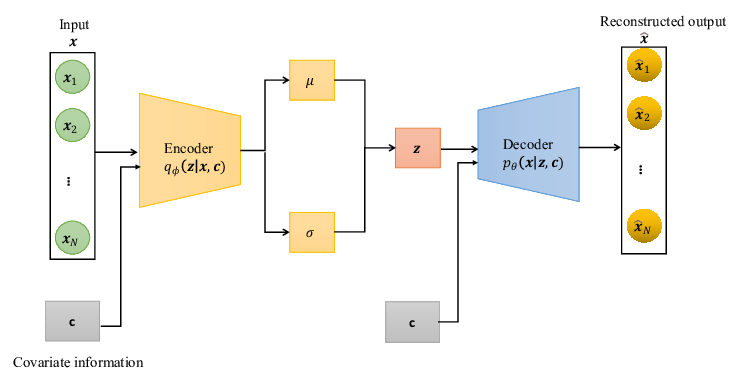

**CVAE是一个将监督学习的理念应用在无监督生成框架中的混合模型。**

**CVAE与VAE的核心区别**

在您开始看代码之前，我们先来建立一个清晰的概念。

1. 标准VAE (Variational Autoencoder)：

* 编码器接收一张图片 x，并学习一个潜在（latent）概率分布 p(z|x)，通常是高斯分布的均值 μ 和对数方差 log_var。

* 解码器从这个分布中采样一个潜在向量 z，并尝试重构原始图片 p(x|z)。

* 在生成新图片时，我们从一个先验分布（通常是标准正态分布 N(0, I)）中采样一个 z，然后将其送入解码器。因为解码器没有其他信息，所以它会生成一个“随机”的、数据集中看起来很真实的图片，但我们无法控制它生成的是猫还是狗。

2. 条件VAE (Conditional VAE)：

* CVAE的核心思想是增加一个条件 c （在我们的案例中，是图片的类别标签），来控制生成过程。

* 编码器接收图片 x 和它的条件 c，学习 p(z|x, c)。这意味着潜在空间现在也依赖于类别信息。

* 解码器接收潜在向量 z 和我们想要生成的条件 c，并学习 p(x|z, c)。

* 在生成新图片时，我们从先验分布中采样一个 z，然后选择一个我们想要的条件 c（例如，“我想要一只鸟”），并将两者一起送入解码器。解码器现在知道我们的意图，并会生成一张符合条件 c 的图片。

* 实现方式：最简单直接的方法是将条件 c（通常是一个独热编码向量）与图片数据和潜在向量在相应阶段进行拼接（concatenate）。



[Image Source](https://www.researchgate.net/figure/Structure-of-the-conditional-variational-autoencoder-CVAE_fig2_365190062)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")
print(f"当前使用的设备是: {device}")

Using MPS device for Apple Silicon GPU acceleration.
当前使用的设备是: mps


In [3]:

class Dataset(torchvision.datasets.CIFAR10):
    def __init__(self, path, image_dims=(32, 32), n_channels=3, train=True):
        transform = transforms.Compose([
            transforms.Resize(image_dims),
            transforms.ToTensor()
        ])
        super().__init__(path, train=train, transform=transform, download=True)
        self.n_classes = 10
        self.image_dims = image_dims
        self.n_channels = n_channels
        self.resize = transforms.Resize(image_dims)
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        # 将标签转换为独热编码，这是我们的条件 'c'
        one_hot_label = torch.nn.functional.one_hot(torch.tensor(label), num_classes=self.n_classes).float()
        return image, one_hot_label, label

In [4]:
train_dataset = Dataset(path="./data", train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


In [5]:
def show_batch(loader, class_names=None):
    images, one_hot_labels, raw_labels = next(iter(loader))
    plt.figure(figsize=(12, 6))
    for i in range(10):
        img = images[i].permute(1, 2, 0).numpy()
        label = raw_labels[i].item()
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        if class_names:
            plt.title(class_names[label])
        else:
            plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

Train Set Sample:


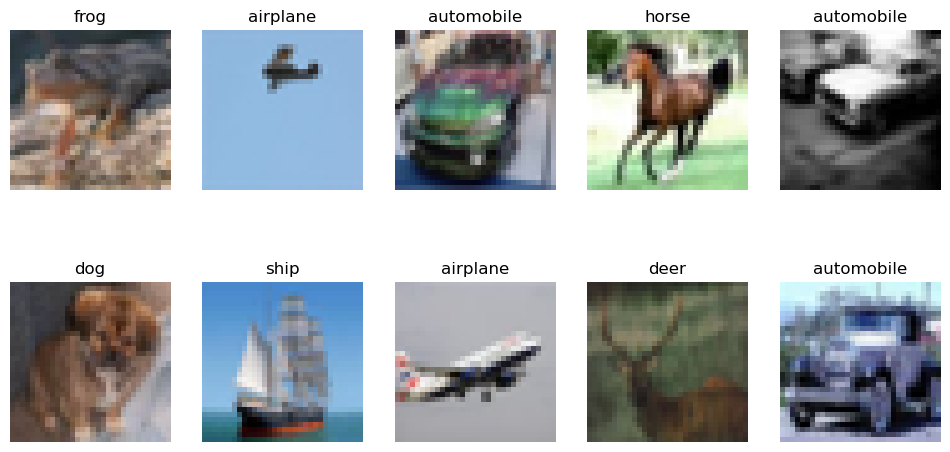

In [6]:
# Class names for CIFAR-10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Show one batch from each
print("Train Set Sample:")
show_batch(train_loader, class_names)

[B, 3(img)+10(label), 32, 32]

B (Batch Size): 表示我们一次处理了多少张图片。如果 B=64，就意味着我们把64张图片和它们对应的64个标签打包在一起，作为一个“批次” (Batch) 送入模型。

3: 图像的通道数 (RGB)。

10: one-hot编码后的类别数。

32, 32: 图像的高度和宽度。

In [ ]:
class ImprovedConvCVAE(nn.Module):
    def __init__(self, img_channels, latent_dim, num_classes):
        super(ImprovedConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_channels = img_channels

        # --- 编码器 (更深更宽) ---
        # 输入: [B, 3(img)+10(label), 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + num_classes, 64, kernel_size=4, stride=2, padding=1), # -> [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> [B, 128, 8, 8]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # -> [B, 256, 4, 4]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # -> [B, 512, 2, 2]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        # 扁平化后的全连接层
        self.fc_mu = nn.Linear(512 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(512 * 2 * 2, latent_dim)

        # --- 解码器 (更深更宽 + 逐层条件注入) ---
        self.decoder_fc = nn.Linear(latent_dim + num_classes, 512 * 2 * 2)

        # 我们将逐层定义，以便注入条件
        self.upconv1 = self._make_upconv_block(512, 256)
        self.upconv2 = self._make_upconv_block(256, 128)
        self.upconv3 = self._make_upconv_block(128, 64)
        # 最后一层输出图像通道
        self.upconv4 = nn.Sequential(
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def _make_upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )


    # x：输入的图像，形状为 [批量大小, 3, 32, 32]。
    # c：对应的标签（经过one-hot编码），形状为 [批量大小, 10]。这是一个向量。
    def encode(self, x, c):
        c_img = c.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, x.size(2), x.size(3))
        x_cond = torch.cat([x, c_img], dim=1)
        # x 的形状是 [B, 3, 32, 32]。
        # c_img 的形状是 [B, 10, 32, 32]。
        # 拼接后的 x_cond 形状变为 [B, 3 + 10, 32, 32]，即 [B, 13, 32, 32]。
        h = self.encoder(x_cond)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)
    # c.unsqueeze(-1).unsqueeze(-1): 这两步的目的是给标签向量 c 增加两个维度，使其从 [B, 10] 变为 [B, 10, 1, 1]。这样做是为了让它能够与四维的图像张量 x 在空间上进行广播（broadcast）或重复。
    # .repeat(1, 1, x.size(2), x.size(3)): 这一步是关键。它将 [B, 10, 1, 1] 的张量在最后两个维度（高度和宽度）上进行重复，重复的次数与输入图像 x 的高（x.size(2)即32）和宽（x.size(3)即32）完全一致。

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        h = self.decoder_fc(z_cond)
        h = h.view(h.size(0), 512, 2, 2) # 重塑为初始特征图
        
        # 逐层上采样并注入条件
        h = self.upconv1(h) # -> [B, 256, 4, 4]
        h = self.upconv2(h) # -> [B, 128, 8, 8]
        h = self.upconv3(h) # -> [B, 64, 16, 16]
        img_recon = self.upconv4(h) # -> [B, 3, 32, 32]
        
        return img_recon

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

编码器的目标是将输入的图像 x（在标签 c 的条件下）压缩成一个潜在空间分布（由 mu 和 logvar 描述）。为了让卷积网络从一开始就“意识”到这个条件，代码采用了一种非常直观的方法：将条件信息变成一个“图像通道”，然后与原始图像拼接在一起。

Actually, in our early modification of this model, we find that the image generated is just rubbish. We cannot see a clear boundary for the items.

So, we modified the layers and adjust the beta parameter.

通过设置一个小于1的β值（例如β=0.1），我们是在告诉模型：“**你可以稍微放松对潜在空间必须严格服从标准正态分布的要求，我更关心你能不能把图片清晰地重建出来**”。

这会迫使编码器将更多有效信息编码到z中，从而让解码器有足够的信息生成清晰的图像。

In [8]:
# β-VAE 损失函数 = 重构损失 + β * KL散度
def loss_function(x_recon, x, mu, logvar, beta):
    # 重构损失
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    
    # KL散度
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD

# --- 超参数 ---
IMG_CHANNELS = 3
LATENT_DIM = 128
NUM_CLASSES = 10
EPOCHS = 200      # 更复杂的模型需要更多的训练
BETA = 0.1       # 这是β-VAE的核心，小于1以强调重建

# 实例化模型和优化器
model = ImprovedConvCVAE(img_channels=IMG_CHANNELS, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("ImprovedConvCVAE Model Architecture:")
print(model)

ImprovedConvCVAE Model Architecture:
ImprovedConvCVAE(
  (encoder): Sequential(
    (0): Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=2048, out_features=128, bias=True)
  (fc_logvar): Linear(in_feat

In [9]:
# 训练循环
model.train()
for epoch in range(EPOCHS):
    train_loss = 0
    for i, (images, one_hot_labels, _) in enumerate(train_loader):
        images = images.to(device)
        one_hot_labels = one_hot_labels.to(device)

        # 前向传播
        recon_images, mu, logvar = model(images, one_hot_labels)
        
        # 计算损失 (传入BETA值)
        loss = loss_function(recon_images, images, mu, logvar, BETA)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()/len(images):.4f}")

    print(f"====> Epoch: {epoch+1} Average loss: {train_loss / len(train_loader.dataset):.4f} ====")

print("Training finished.")

Epoch [1/200], Step [100/391], Loss: 1873.7292
Epoch [1/200], Step [200/391], Loss: 1820.3752
Epoch [1/200], Step [300/391], Loss: 1830.2783
====> Epoch: 1 Average loss: 1852.0485 ====
Epoch [2/200], Step [100/391], Loss: 1782.3552
Epoch [2/200], Step [200/391], Loss: 1775.6345
Epoch [2/200], Step [300/391], Loss: 1794.2676
====> Epoch: 2 Average loss: 1782.7394 ====
Epoch [3/200], Step [100/391], Loss: 1791.3475
Epoch [3/200], Step [200/391], Loss: 1778.0104
Epoch [3/200], Step [300/391], Loss: 1761.6128
====> Epoch: 3 Average loss: 1768.0287 ====
Epoch [4/200], Step [100/391], Loss: 1736.1945
Epoch [4/200], Step [200/391], Loss: 1806.9670
Epoch [4/200], Step [300/391], Loss: 1757.5723
====> Epoch: 4 Average loss: 1760.7439 ====
Epoch [5/200], Step [100/391], Loss: 1770.5624
Epoch [5/200], Step [200/391], Loss: 1755.6433
Epoch [5/200], Step [300/391], Loss: 1735.0544
====> Epoch: 5 Average loss: 1757.1233 ====
Epoch [6/200], Step [100/391], Loss: 1747.6163
Epoch [6/200], Step [200/391

Generating images for class: 'airplane'


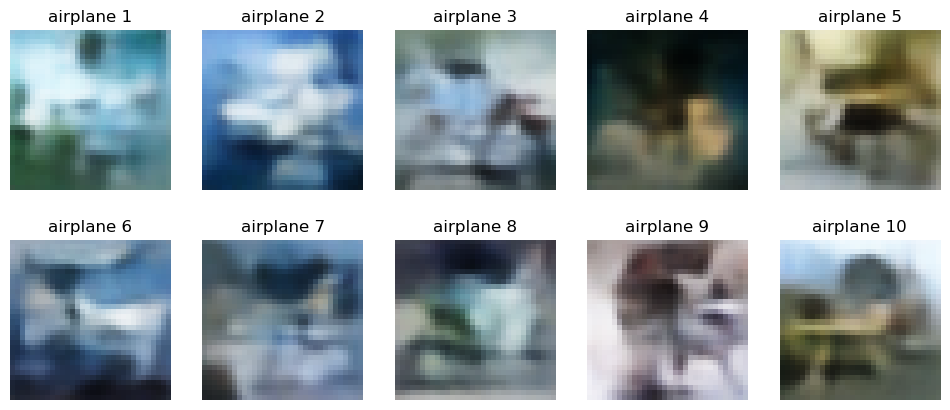

Generating images for class: 'automobile'


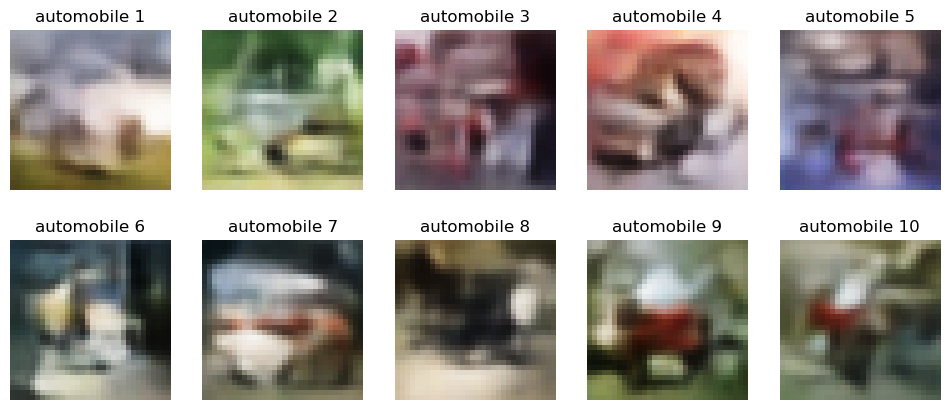

Generating images for class: 'bird'


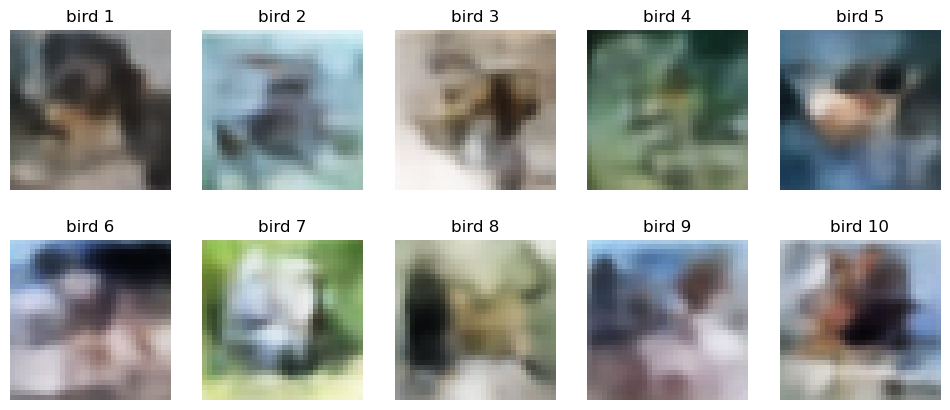

Generating images for class: 'cat'


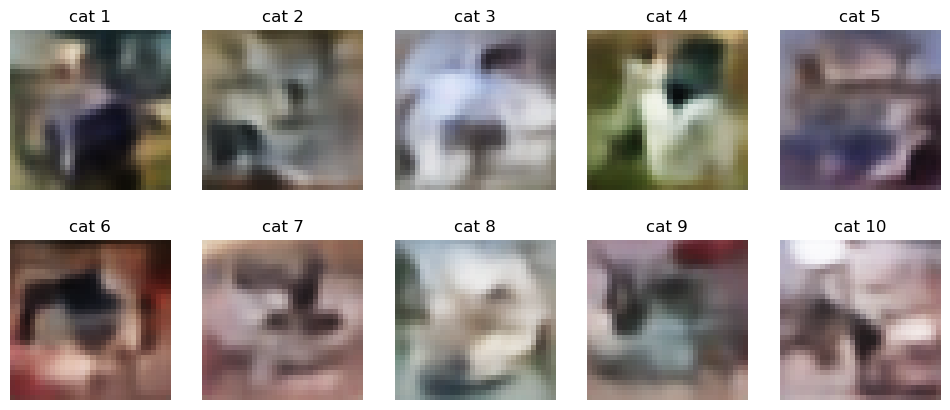

Generating images for class: 'deer'


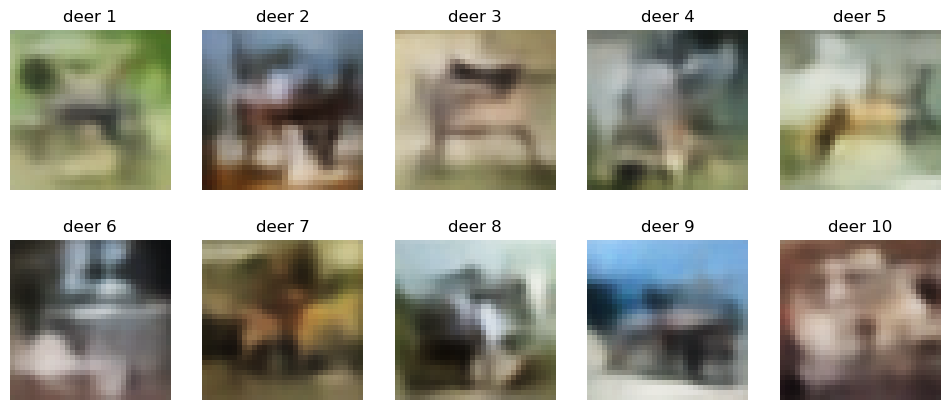

Generating images for class: 'dog'


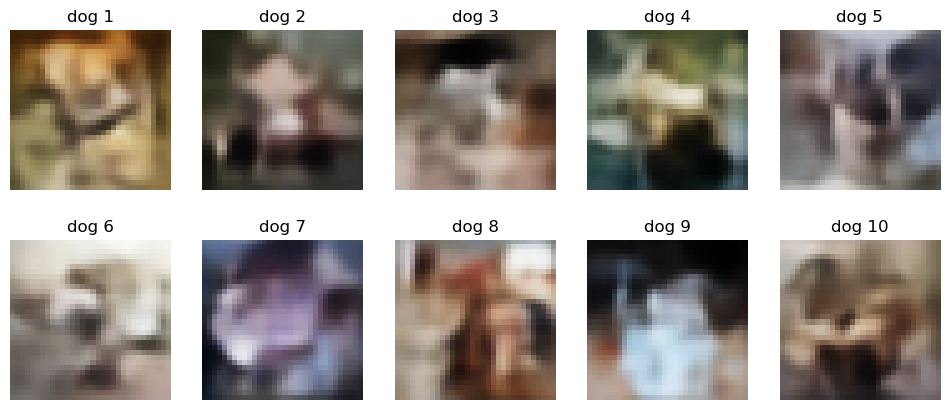

Generating images for class: 'frog'


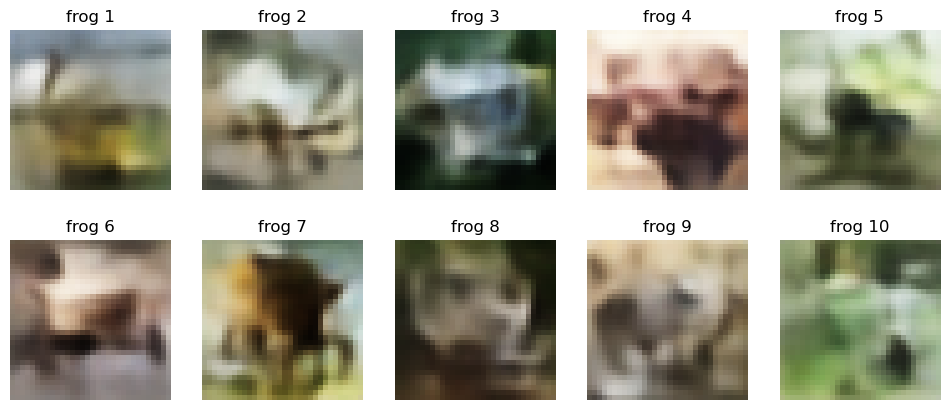

Generating images for class: 'horse'


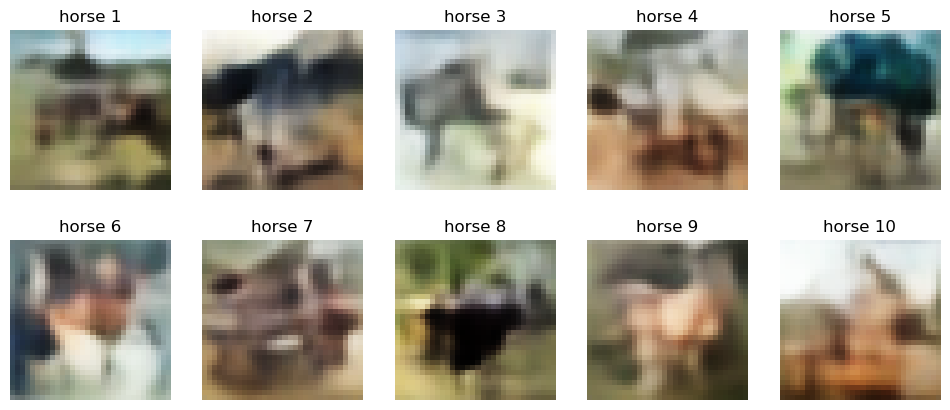

Generating images for class: 'ship'


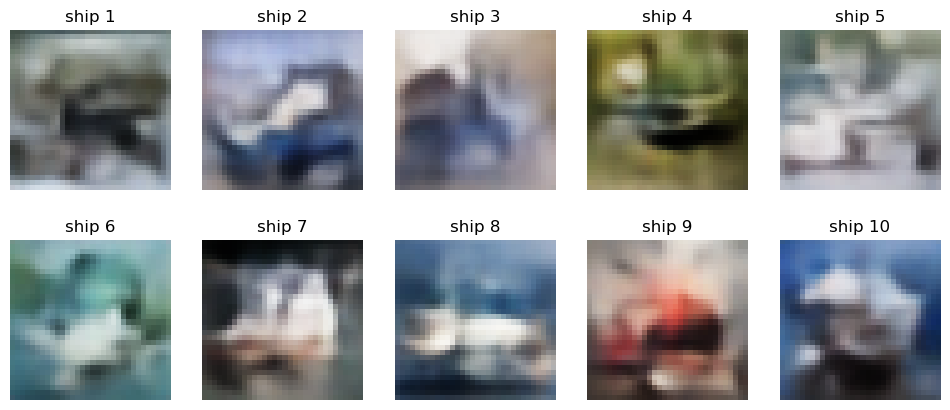

Generating images for class: 'truck'


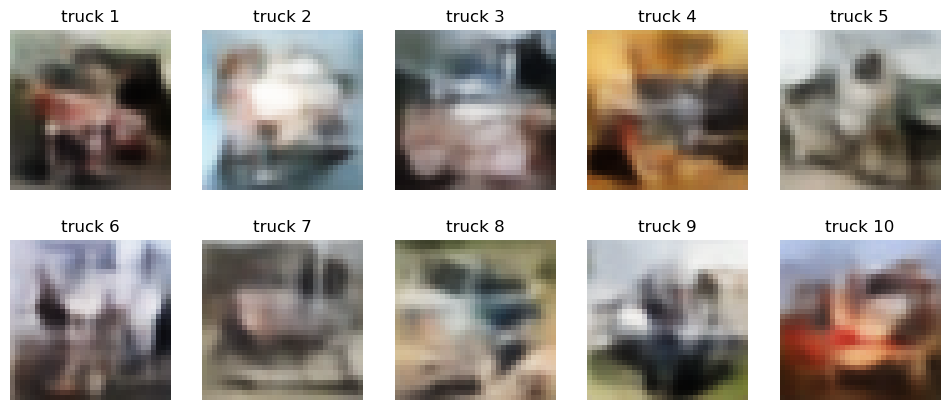

In [17]:
# 生成并展示每个类别的10张图片
model.eval()

IMG_SIZE = 32
IMG_CHANNELS = 3

with torch.no_grad():
    samples_per_class = 10
    
    # 遍历每个类别 (0-9)
    for i, class_name in enumerate(class_names):
        print(f"Generating images for class: '{class_name}'")
        
        # 1. 创建条件向量 'c'
        # 我们为当前类别 'i' 创建一个独热编码向量
        label_tensor = torch.tensor([i]).to(device)
        one_hot_label = F.one_hot(label_tensor, num_classes=NUM_CLASSES).float()
        
        # 2. 重复 'c' 以生成一个批次
        # 我们想要一次性生成10张图片，所以我们将这个独热向量复制10次
        c = one_hot_label.repeat(samples_per_class, 1)

        # 3. 从先验分布中采样潜在向量 'z'
        # 我们从标准正态分布中采样10个随机噪声向量
        z = torch.randn(samples_per_class, LATENT_DIM).to(device)

        # 4. 使用解码器生成图像
        # 这是CVAE的魅力所在：我们提供噪声'z'和我们想要的条件'c'
        generated_images = model.decode(z, c).cpu()

        # 5. 显示生成的图像
        plt.figure(figsize=(12, 5))
        for j in range(samples_per_class):
            img = generated_images[j].view(IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            img = img.permute(1, 2, 0).numpy() # 调整维度以适应matplotlib
            
            plt.subplot(2, 5, j + 1)
            plt.imshow(img)
            plt.title(f"{class_name} {j+1}")
            plt.axis("off")
        plt.show()

**即使是一个结构良好、实现正确的标准CVAE，在处理像CIFAR-10这样复杂的真实世界图像时，其固有的数学原理仍然会导致生成图像模糊、细节丢失。**